## Initial configuration

In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2
import gc
from tqdm import tqdm,trange

import torch
from torchsummary import summary
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

import urllib.request
import zipfile
import json

In [2]:
#Usefull for better outputs visualization
PURPLE = "\033[95m"
CYAN = "\033[96m"
DARKCYAN = "\033[36m"
BLUE = "\033[94m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"
END = "\033[0m"

### Project settings

In [3]:
data_dir_unsplitted = "dataset/unsplitted"
save_dir_splitted = "dataset/splitted"
data_dir = "dataset/splitted"
models_dir ="models/" #the resuls will be saved here

os.makedirs(models_dir,exist_ok=True)


patch_size = 128
n_samples = 40
batch_size = 40


grayscale= False
resize_to= None
fft = False


learning_rate_e = 0.001
learning_rate_d = 0.001
#learning_rate_c = 0.00001
num_epochs = 50


#@DEPRECATED VARIABLE
ALREADY_SPLITTED = True #-> we will use only "LOAD_DATASET"


LOAD_DATASET = True #if true "ALREADY_SPLITTED" is ignored

#to be implemented:

DATASET_ALREADY_DOWNLOADED = True 
DATASET_ALREADY_UNZIPPED = True

LOAD_MODEL = False 
MODEL_ALREADY_DOWNLOADED = True 

## Dataset preparation

### Dataset splitting and data augmentation

In [4]:
classes = ["CLL", "FL", "MCL"]
id_to_name = {0:"CLL",1:"FL",2:"MCL"}

if(not ALREADY_SPLITTED or not LOAD_DATASET):
    data = []
    labels = []
    for i, cl in enumerate(classes):
        path = os.path.join(data_dir_unsplitted, cl)
        images = os.listdir(path)
        for img in tqdm(images,desc=cl):
            img_path = os.path.join(path, img)
            img = cv2.imread(img_path).astype(np.uint8)
            
            data.append(img)
            labels.append(i) 


    data = np.array(data)
    labels = np.array(labels)


    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)


    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.125, random_state=42)

    print("Train samples:", len(train_data))
    print("Test samples:", len(test_data))
    print("Validation samples:", len(val_data))

### Saving the splitted dataset

In [5]:
def crop_image(image, patch_size, n_samples = 40):
    h, w, _ = image.shape
    h_eff = h - patch_size
    w_eff = w - patch_size
    samples = []
    
    for i in range(n_samples):
        h_vertex = np.random.randint(h_eff)
        w_vertex = np.random.randint(w_eff)
        samples.append(image[h_vertex:h_vertex+patch_size, w_vertex:w_vertex+patch_size, :])
    
    samples = np.stack(samples)
    return samples   

In [6]:
#SAVING THE DATASET
if(not ALREADY_SPLITTED or not LOAD_DATASET):
    #TRAIN
    os.makedirs(os.path.join(save_dir_splitted,"train","images"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"train","images_patch"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"train","labels"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"train","labels_patch"),exist_ok=True)
     
    train_labels_dict={}
    train_labels_patch_dict={}
    
    for i, image in enumerate(tqdm(train_data,desc = "Train")):                       #images
        file_name = str(i)+"_train"+".png"
        
        path = os.path.join(save_dir_splitted,"train","images",file_name)
        train_labels_dict[file_name] = int(train_labels[i])
        cv2.imwrite(path,image.astype(np.float64))
        
        image_patch = crop_image(image, patch_size, n_samples)
        for j in range(len(image_patch)):
            file_name = str(i)+"-"+str(j)+"_train"+".png"
            path = os.path.join(save_dir_splitted,"train","images_patch",file_name)
            train_labels_patch_dict[file_name] = int(train_labels[i])
            cv2.imwrite(path,image_patch[j].astype(np.float64))
       
    
    
    with open(os.path.join(save_dir_splitted,"train","labels","train.json"), 'w') as f:
        json.dump(train_labels_dict, f)#labels
    with open(os.path.join(save_dir_splitted,"train","labels_patch","train_patch.json"), 'w') as f:
        json.dump(train_labels_patch_dict, f)#labels

    #TEST
    os.makedirs(os.path.join(save_dir_splitted,"test","images"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"test","images_patch"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"test","labels"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"test","labels_patch"),exist_ok=True)

    test_labels_dict={}
    test_labels_patch_dict={}
    
    for i, image in enumerate(tqdm(test_data,desc = "Test")):                      #images
        file_name = str(i)+"_test"+".png"
        path = os.path.join(save_dir_splitted,"test","images",file_name)
        
        cv2.imwrite(path,image.astype(np.float64))
        test_labels_dict[file_name] = int(test_labels[i]) 
        
        image_patch = crop_image(image, patch_size, n_samples)
        for j in range(len(image_patch)):
            file_name = str(i)+"-"+str(j)+"_test"+".png"
            path = os.path.join(save_dir_splitted,"test","images_patch",file_name)
            test_labels_patch_dict[file_name] = int(test_labels[i])
            cv2.imwrite(path,image_patch[j].astype(np.float64))

    with open(os.path.join(save_dir_splitted,"test","labels","test.json"), 'w') as f:
        json.dump(test_labels_dict, f)#labels
    with open(os.path.join(save_dir_splitted,"test","labels_patch","test_patch.json"), 'w') as f:
        json.dump(test_labels_patch_dict, f)#labels
        
    #VALIDATION
    os.makedirs(os.path.join(save_dir_splitted,"val","images"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"val","images_patch"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"val","labels"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"val","labels_patch"),exist_ok=True)
    
    val_labels_dict = {}
    val_labels_patch_dict = {}
    
    for i, image in enumerate(tqdm(val_data,desc = "Validation")):               #images
        file_name = str(i)+"_val"+".png"
        path = os.path.join(save_dir_splitted,"val","images",file_name)
        
        cv2.imwrite(path,image.astype(np.float64))
        val_labels_dict[file_name] = int(val_labels[i])
        
        image_patch = crop_image(image, patch_size, n_samples)
        for j in range(len(image_patch)):
            file_name = str(i)+"-"+str(j)+"_val"+".png"
            path = os.path.join(save_dir_splitted,"val","images_patch",file_name)
            val_labels_patch_dict[file_name] = int(val_labels[i])
            cv2.imwrite(path,image_patch[j].astype(np.float64))
        
    with open(os.path.join(save_dir_splitted,"val","labels","val.json"), 'w') as f:
        json.dump(val_labels_dict, f)#labels
    with open(os.path.join(save_dir_splitted,"val","labels_patch","val_patch.json"), 'w') as f:
        json.dump(val_labels_patch_dict, f)#labels

### Dataloaders definition

Notice that the labels are saved into a numpy array, while the images are read directly from the folder

In [7]:
class HDAdataset(Dataset):
    def __init__(self, root_dir, labels, train = False, transform=None, grayscale= False, resize_to= None, fft = False):
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform
        self.train = train
        self.grayscale=grayscale
        self.fft = fft
        self.resize_to = resize_to

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        img_name = os.listdir(self.root_dir)[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        if self.grayscale or self.fft:
            image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
            
        else:
            image = cv2.imread(img_path)

        
        if self.train:
            image = image.astype(np.uint8) + np.random.normal(0, 2, image.shape).astype(np.uint8)
        
        if self.resize_to is not None:
            image = cv2.resize(image, resize_to, interpolation= cv2.INTER_LINEAR)
            
        if self.fft:
            image = np.fft.fft2(image)
            fshift = np.fft.fftshift(image)
            magnitude_spectrum = 20*np.log(np.abs(fshift))
            image = magnitude_spectrum
        

        
        #labels smoothing
        label = 0.1*np.ones(3)
        label[self.labels[img_name]] = 0.8
        
        if self.transform:
            image = self.transform((image/255.).astype(np.float32))

        return image, label

In [8]:
class HDAdatasetPatches(Dataset):
    def __init__(self, root_dir,patch_dir, labels, train = False, transform=None, grayscale= False, fft = False):
        self.root_dir = root_dir
        self.patch_dir = patch_dir
        self.labels = labels
        self.transform = transform
        self.train = train
        self.grayscale=grayscale
        self.fft = fft

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        img_name = os.listdir(self.root_dir)[idx]
        img_id = int(img_name.split("_")[0])
        
        patches_list = os.listdir(self.patch_dir)
        patches_image_list = list(filter(lambda name: int(name.split("-")[0]) == img_id, patches_list))
        
        all_patches = []
        for patch in patches_image_list:
            patch_path = os.path.join(self.patch_dir, patch)
            

            if self.grayscale or self.fft:
                image = cv2.imread(patch_path,cv2.IMREAD_GRAYSCALE)
                channels = 1
            
            else:
                image = cv2.imread(patch_path)
                channels = 3

            if self.train:
                image = image.astype(np.uint8) + np.random.normal(0, 2, image.shape).astype(np.uint8)

            if self.fft:
                image = np.fft.fft2(image)
                fshift = np.fft.fftshift(image)
                magnitude_spectrum = 20*np.log(np.abs(fshift))
                image = magnitude_spectrum
            
            image = (image/255.).astype(np.float32)
            image = image.reshape(image.shape[0],image.shape[1],channels)
            image = np.transpose(image, (2, 0, 1))
            all_patches.append(image.reshape(1,image.shape[0],image.shape[1],image.shape[2]))

        all_patches=np.stack(all_patches)
        
        #labels smoothing
        label = 0.1*np.ones(3)
        label[self.labels[img_name]] = 0.8

        return all_patches, label.reshape(1,label.shape[0])

In [9]:
transform = transforms.Compose([transforms.ToTensor()]) 


In [11]:
if(LOAD_DATASET and not DATASET_ALREADY_DOWNLOADED):
    
    print("download and extract the datasets")
    urllib.request.urlretrieve("", "dataset.zip")
    
    with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("./dataset/")

#convert to tensor each image
transform = transforms.Compose([transforms.ToTensor()])    

#TRAIN DATASET AND DATALOADER
train_dir = os.path.join(data_dir,"train","images_patch")#images
train_labels_dir = os.path.join(data_dir,"train","labels_patch","train_patch.json")
with open(train_labels_dir) as f:
    train_labels = json.load(f)#labels

train_dataset = HDAdataset(train_dir,train_labels,train = True, transform=transform,grayscale=grayscale)
train_data = [data for data in tqdm(train_dataset)] #using a list to increase the training speed since the data fit in the ram
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

#TEST DATASET AND DATALOADER
test_dir = os.path.join(data_dir,"test","images")#images
test_dir_patches = os.path.join(data_dir,"test","images_patch")#patches
test_labels_dir = os.path.join(data_dir,"test","labels","test.json")
with open(test_labels_dir) as f:
    test_labels = json.load(f)#labels

test_dataset = HDAdatasetPatches(test_dir,test_dir_patches,test_labels,train = False,
                          transform=None,grayscale=grayscale,fft=fft)

#test_dataloader = DataLoader(test_dataset, batch_size=n_samples, shuffle=False)

#VALIDATION DATASET AND DATALOADER
val_dir = os.path.join(data_dir,"val","images")#images
val_dir_patches = os.path.join(data_dir,"val","images_patch")#patches
val_labels_dir = os.path.join(data_dir,"val","labels","val.json")
with open(val_labels_dir) as f:
    val_labels = json.load(f)#labels

val_dataset = HDAdatasetPatches(val_dir,val_dir_patches,val_labels,train = False,
                          transform=None,grayscale=grayscale,fft=fft)

#val_dataloader = DataLoader(val_dataset, batch_size=n_samples, shuffle=False)

100%|██████████| 10440/10440 [01:59<00:00, 87.06it/s]


## Neural network

In [12]:
torch.cuda.empty_cache()
gc.collect()

41

### Models definition

In [13]:
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
#             ### 6x128x128
#             #nn.MaxPool2d(2),
#             ### 6x64x64
#             nn.BatchNorm2d(16),
#             nn.LeakyReLU(),
#             #nn.Dropout(p=0.1),
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
#             ### 9x22x22
#             #nn.MaxPool2d(2),
#             ### 9x11x11
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(),
#             #nn.Dropout(p=0.1),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
#             ### 12x4x4
#             #nn.MaxPool2d(2),
#             ### 12x2x2
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(),
#             nn.Flatten(),
#             ### 12*2*2
#             #nn.Dropout(p=0.1),
#             nn.Linear(16384,150),
#             nn.BatchNorm1d(150),
#             nn.LeakyReLU(),
#             nn.Dropout(p=0.2),
#             nn.Linear(150,20),
#             nn.LeakyReLU(),
#         )

#         self.classification = nn.Sequential(
#             nn.Linear(20,10),
#             nn.BatchNorm1d(10),
#             nn.LeakyReLU(),
#             nn.Dropout(p=0.2),
#             nn.Linear(10,3),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         return x, self.classification(x)
    
# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
        
#         self.decoder = nn.Sequential(
#             nn.Linear(20,150),
#             nn.BatchNorm1d(150),
#             nn.LeakyReLU(),
#             #nn.Dropout(p=0.1),
#             nn.Linear(150,16384),
#             nn.BatchNorm1d(16384),
#             nn.LeakyReLU(),
#             #nn.Dropout(p=0.1),
#             nn.Unflatten(-1, (64,16,16)),
#             #nn.Upsample(size=(8, 8), mode='bilinear'),
#             nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(),
#             #nn.Dropout(p=0.1),
#             #nn.Upsample(size=(32, 32), mode='bilinear'),
#             nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=(0,0)),
#             nn.BatchNorm2d(16),
#             nn.LeakyReLU(),
#             #nn.Dropout(p=0.1),
#             #nn.Upsample(size=(128, 128), mode='bilinear'),
#             nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(3,3), stride=(2,2), padding=(0,0), dilation=1,output_padding=(1,1)),
#             nn.Sigmoid()
#         )
#     def forward(self, x):
#         x = self.decoder(x)
        
#         return x

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        #encoder
        self.convE1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convE2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convE3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.flatten = nn.Flatten()
        self.BNE16 = nn.BatchNorm2d(16)
        self.BNE32 = nn.BatchNorm2d(32)
        self.BNE64 = nn.BatchNorm2d(64)
        self.linearE1 = nn.Linear(14400,50)
        self.linearE2 = nn.Linear(50,3)
        self.BNE150linear = nn.BatchNorm1d(50)
        
        self.act = nn.LeakyReLU()
        self.drop = nn.Dropout(p=0.2)
        
        #decoder
        
        self.convD1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convD2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convD3 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=(3,3), 
                                         stride=(2,2), padding=(0,0), dilation=1,output_padding=(1,1))
        self.reshape = nn.Unflatten(-1, (64,15,15))
        self.BND16 = nn.BatchNorm2d(16)
        self.BND32 = nn.BatchNorm2d(32)
        self.linearD1 = nn.Linear(3,50)
        self.linearD2 = nn.Linear(50,14400)
        self.BND150linear = nn.BatchNorm1d(50)
        self.BND16klinear = nn.BatchNorm1d(14400)
        
        self.out = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):

        x1 = self.act(self.BNE16(self.convE1(x)))
        x2 = self.act(self.BNE32(self.convE2(x1)))
        x3 = self.act(self.BNE64(self.convE3(x2)))
        x3linear = self.flatten(x3)
        x4 = self.drop(self.act(self.BNE150linear(self.linearE1(x3linear))))
        x5 = self.linearE2(x4)

        x = self.act(self.BND150linear(self.linearD1(x5)))
        x = self.act(self.BND16klinear(self.linearD2(x+x4)))
        x = self.reshape(x)
        x = self.act(self.BND32(self.convD1(x+x3)))
        x = self.act(self.BND16(self.convD2(x+x2)))
        x = self.out(self.convD3(x+x1))

        return x,self.softmax(x5)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(BOLD+"You are working on: "+END+str(device))

You are working on: cpu


### Loading of the models

In [16]:
if(LOAD_MODEL and not MODEL_ALREADY_DOWNLOADED):
    print("download the model")

In [19]:
if(not LOAD_MODEL):
    autoencoder = Autoencoder().to(device)
    #classifier = Classifier().to(device)

In [20]:
summary(autoencoder, (3, 128, 128),batch_size=2)

# summary(encoder, (1, 128, 128),batch_size=40)
# summary(decoder, (20, ), batch_size=40)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [2, 16, 63, 63]             448
       BatchNorm2d-2            [2, 16, 63, 63]              32
         LeakyReLU-3            [2, 16, 63, 63]               0
            Conv2d-4            [2, 32, 31, 31]           4,640
       BatchNorm2d-5            [2, 32, 31, 31]              64
         LeakyReLU-6            [2, 32, 31, 31]               0
            Conv2d-7            [2, 64, 15, 15]          18,496
       BatchNorm2d-8            [2, 64, 15, 15]             128
         LeakyReLU-9            [2, 64, 15, 15]               0
          Flatten-10                 [2, 14400]               0
           Linear-11                    [2, 50]         720,050
      BatchNorm1d-12                    [2, 50]             100
        LeakyReLU-13                    [2, 50]               0
          Dropout-14                   

### Training 

The accuracy in the training is patch wise while the accuracy in validation and test is image wise(i.e. the most common class for the patches of the same image)

In [21]:
def test(dataset,name):
    
    losses_ae = []
    losses_c = []
    count_correct = 0
    count_input = 0
    count_correct_patches = 0
    count_input_patches = 0

    autoencoder.eval()
    
    #single image
    for data in tqdm(dataset,desc = name +" set"):
        pred = []
        labels = torch.tensor(data[1]).to(device)
        true_image_label = labels.to("cpu").detach().numpy().argmax(axis=1)[0]
        
        #iterate over all the patches
        for patch in data[0]:
            
            img = torch.tensor(patch).to(device)
            
            rec_img,pred_labels= autoencoder(img)  
            
            classifier_loss = criterion_classifier(pred_labels, labels)
            ae_loss= criterion_ae(img,rec_img)
            
            count_input_patches += 1
            count_correct_patches += (pred_labels.to("cpu").detach().numpy().argmax(axis=1)[0] == true_image_label)

            losses_ae.append(ae_loss.detach().cpu().numpy())
            losses_c.append(classifier_loss.detach().cpu().numpy())
            
            pred.append(pred_labels.to("cpu").detach().numpy().argmax(axis=1)[0])
            
            
        count_input += 1
            
        final_image_label = max(set(pred), key=pred.count) 
        count_correct+= (final_image_label == true_image_label)
        
        del img
        del labels
        torch.cuda.empty_cache()
        gc.collect();

    # Print loss at end of each epoch
    accuracy= (count_correct/count_input)*100.
    accuracy_patches = (count_correct_patches/count_input_patches)*100.
    print(name,': Autoencoder Loss: %.4f, Classifier Loss: %.4f,\n Accuracy patches: %.4f in %d input samples, Accuracy: %.4f in %d input samples\n'
      % (np.mean(losses_ae), np.mean(losses_c),accuracy_patches,count_input_patches,accuracy,count_input))
    
    return np.mean(losses_ae),np.mean(losses_c), accuracy_patches, accuracy

In [24]:
criterion_classifier = nn.CrossEntropyLoss()
criterion_ae = nn.MSELoss()

def train(train_dataloader,val_dataset):
    optimizer_ae = optim.RMSprop(autoencoder.parameters(), lr=learning_rate_e,weight_decay=1e-3)

    
    
    best_epoch = 0 #(based on the validation accuracy)
    best_accuracy = -np.inf
    
    #for plotting
    train_loss_ae_trend = []
    train_loss_c_trend = []
    train_accuracy_trend =[]
    val_loss_ae_trend = []
    val_loss_c_trend = []
    val_accuracy_trend = []

    
    for epoch in range(num_epochs):

        ######training#####
        losses_ae = []
        losses_c = []
        count_correct = 0
        count_input = 0

        autoencoder.train()
       
        
        #train classifier for one epoch    
        for data in tqdm(train_dataloader,desc = "Train classifier Epoch [%d/%d]"%(epoch+1,num_epochs)):

            img, labels = data
            img = torch.tensor(img).to(device)
            labels = torch.tensor(labels).to(device)
            
           
            
            optimizer_ae.zero_grad()
            
            
            rec_img,pred_labels= autoencoder(img)  
            

            classifier_loss = criterion_classifier(pred_labels, labels)
            ae_loss = criterion_ae(img,rec_img)
            total_loss = classifier_loss+10*ae_loss
            
            total_loss.backward()
            
            optimizer_ae.step()
            
            losses_ae.append(ae_loss.detach().cpu().numpy())
            losses_c.append(classifier_loss.detach().cpu().numpy())

            
            count_input+=pred_labels.detach().cpu().numpy().shape[0]
            count_correct+=np.sum((labels.to("cpu").detach().numpy().argmax(axis=1)==pred_labels.to("cpu").detach().numpy().argmax(axis=1)))
            del img
            del labels
            torch.cuda.empty_cache()
            gc.collect();
            
        accuracy = (count_correct/count_input)*100.
        
        print('TRAIN: Epoch [%d/%d], Autoencoder Loss: %.4f, Classifier Loss: %.4f, Accuracy: %.4f in %d input patches \n'
              % (epoch+1, num_epochs, np.mean(losses_ae), np.mean(losses_c),accuracy,count_input))
        
        train_loss_ae_trend.append(np.mean(losses_ae))
        train_loss_c_trend.append(np.mean(losses_c))
        train_accuracy_trend.append(accuracy)
        
        ######validation######
        ae,c,acc_p,acc= test(val_dataset,"VALIDATION")
        
        val_loss_ae_trend.append(ae)
        val_loss_c_trend.append(c)
        val_accuracy_trend.append(acc)
        
        if acc > best_accuracy:
            print(GREEN+"Saved Model: "+END+UNDERLINE+"best validation accuracy reached\n\n"+END)
            best_epoch = epoch+1
            torch.save(autoencoder.state_dict(), os.path.join(models_dir,"best_ae.pt"))
            
            best_accuracy = acc

    return np.array([[train_loss_ae_trend,train_loss_c_trend,train_accuracy_trend],
            [val_loss_ae_trend,val_loss_c_trend,val_accuracy_trend],best_epoch],dtype=np.object_)

In [25]:
#training or loading the results of a pretrained model
if(not LOAD_MODEL):
    results = train(train_dataloader,val_dataset) 
    np.save(os.path.join(models_dir,"results.npy"),results)
    
else: 
    results = np.load(os.path.join(models_dir,"results.npy"),allow_pickle=True)

Train classifier Epoch [1/50]:   0%|          | 0/261 [00:00<?, ?it/s]<ipython-input-24-6b4c09530c74>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).to(device)
<ipython-input-24-6b4c09530c74>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [1/50], Autoencoder Loss: 0.0014, Classifier Loss: 0.9286, Accuracy: 73.6398 in 10440 input patches 



Train classifier Epoch [2/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0019, Classifier Loss: 1.0505,
 Accuracy patches: 52.9605 in 1520 input samples, Accuracy: 55.2632 in 38 input samples

Saved Model: best validation accuracy reached




VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [2/50], Autoencoder Loss: 0.0012, Classifier Loss: 0.8766, Accuracy: 81.5038 in 10440 input patches 



Train classifier Epoch [3/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0012, Classifier Loss: 0.9113,
 Accuracy patches: 77.5658 in 1520 input samples, Accuracy: 84.2105 in 38 input samples

Saved Model: best validation accuracy reached




VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [3/50], Autoencoder Loss: 0.0011, Classifier Loss: 0.8641, Accuracy: 83.6207 in 10440 input patches 



Train classifier Epoch [4/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0014, Classifier Loss: 0.9734,
 Accuracy patches: 64.8026 in 1520 input samples, Accuracy: 71.0526 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [4/50], Autoencoder Loss: 0.0011, Classifier Loss: 0.8546, Accuracy: 85.1533 in 10440 input patches 



Train classifier Epoch [5/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0010, Classifier Loss: 1.0183,
 Accuracy patches: 59.4079 in 1520 input samples, Accuracy: 57.8947 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [5/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8500, Accuracy: 85.6226 in 10440 input patches 



Train classifier Epoch [6/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0020, Classifier Loss: 0.8887,
 Accuracy patches: 79.2105 in 1520 input samples, Accuracy: 86.8421 in 38 input samples

Saved Model: best validation accuracy reached




VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [6/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8464, Accuracy: 86.0728 in 10440 input patches 



Train classifier Epoch [7/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.9503,
 Accuracy patches: 70.3947 in 1520 input samples, Accuracy: 71.0526 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [7/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8374, Accuracy: 87.3084 in 10440 input patches 



Train classifier Epoch [8/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0011, Classifier Loss: 0.9338,
 Accuracy patches: 70.7895 in 1520 input samples, Accuracy: 73.6842 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [8/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8339, Accuracy: 88.0077 in 10440 input patches 



Train classifier Epoch [9/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.9492,
 Accuracy patches: 69.2105 in 1520 input samples, Accuracy: 73.6842 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [9/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8293, Accuracy: 88.7548 in 10440 input patches 



Train classifier Epoch [10/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0011, Classifier Loss: 1.0015,
 Accuracy patches: 62.0395 in 1520 input samples, Accuracy: 68.4211 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [10/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8234, Accuracy: 89.8276 in 10440 input patches 



Train classifier Epoch [11/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.9558,
 Accuracy patches: 69.4737 in 1520 input samples, Accuracy: 73.6842 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [11/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8236, Accuracy: 89.6073 in 10440 input patches 



Train classifier Epoch [12/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0013, Classifier Loss: 0.9731,
 Accuracy patches: 67.0395 in 1520 input samples, Accuracy: 73.6842 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [12/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8187, Accuracy: 90.6034 in 10440 input patches 



Train classifier Epoch [13/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.8699,
 Accuracy patches: 82.9605 in 1520 input samples, Accuracy: 89.4737 in 38 input samples

Saved Model: best validation accuracy reached




VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [13/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8164, Accuracy: 90.8046 in 10440 input patches 



Train classifier Epoch [14/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.9162,
 Accuracy patches: 75.0000 in 1520 input samples, Accuracy: 76.3158 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [14/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8136, Accuracy: 91.1111 in 10440 input patches 



Train classifier Epoch [15/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.9167,
 Accuracy patches: 74.8684 in 1520 input samples, Accuracy: 78.9474 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [15/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8097, Accuracy: 91.9444 in 10440 input patches 



Train classifier Epoch [16/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0008, Classifier Loss: 0.8920,
 Accuracy patches: 77.9605 in 1520 input samples, Accuracy: 84.2105 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [16/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8076, Accuracy: 92.0211 in 10440 input patches 



Train classifier Epoch [17/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0013, Classifier Loss: 1.0267,
 Accuracy patches: 58.4868 in 1520 input samples, Accuracy: 55.2632 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [17/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.8044, Accuracy: 92.5575 in 10440 input patches 



Train classifier Epoch [18/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.9313,
 Accuracy patches: 72.1711 in 1520 input samples, Accuracy: 78.9474 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [18/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8056, Accuracy: 92.4330 in 10440 input patches 



Train classifier Epoch [19/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.8872,
 Accuracy patches: 79.8026 in 1520 input samples, Accuracy: 84.2105 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [19/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.8024, Accuracy: 92.9215 in 10440 input patches 



Train classifier Epoch [20/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0012, Classifier Loss: 0.9333,
 Accuracy patches: 72.6316 in 1520 input samples, Accuracy: 78.9474 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [20/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.8014, Accuracy: 93.2471 in 10440 input patches 



Train classifier Epoch [21/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.8475,
 Accuracy patches: 86.0526 in 1520 input samples, Accuracy: 97.3684 in 38 input samples

Saved Model: best validation accuracy reached




VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [21/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7998, Accuracy: 93.2759 in 10440 input patches 



Train classifier Epoch [22/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0008, Classifier Loss: 0.8624,
 Accuracy patches: 82.8289 in 1520 input samples, Accuracy: 92.1053 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [22/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7973, Accuracy: 93.7452 in 10440 input patches 



Train classifier Epoch [23/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0010, Classifier Loss: 0.8526,
 Accuracy patches: 85.1974 in 1520 input samples, Accuracy: 92.1053 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [23/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7974, Accuracy: 93.7739 in 10440 input patches 



Train classifier Epoch [24/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0008, Classifier Loss: 0.8620,
 Accuracy patches: 83.4868 in 1520 input samples, Accuracy: 92.1053 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [24/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7937, Accuracy: 94.3295 in 10440 input patches 



Train classifier Epoch [25/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0013, Classifier Loss: 0.8931,
 Accuracy patches: 78.1579 in 1520 input samples, Accuracy: 81.5789 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [25/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7966, Accuracy: 93.6877 in 10440 input patches 



Train classifier Epoch [26/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.8616,
 Accuracy patches: 83.4868 in 1520 input samples, Accuracy: 86.8421 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [26/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7939, Accuracy: 94.4636 in 10440 input patches 



Train classifier Epoch [27/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.8835,
 Accuracy patches: 80.1316 in 1520 input samples, Accuracy: 81.5789 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [27/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7932, Accuracy: 94.4157 in 10440 input patches 



Train classifier Epoch [28/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0010, Classifier Loss: 0.9537,
 Accuracy patches: 68.2237 in 1520 input samples, Accuracy: 76.3158 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [28/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7894, Accuracy: 95.0575 in 10440 input patches 



Train classifier Epoch [29/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.8673,
 Accuracy patches: 82.7632 in 1520 input samples, Accuracy: 92.1053 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [29/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7905, Accuracy: 94.6264 in 10440 input patches 



Train classifier Epoch [30/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0008, Classifier Loss: 0.8753,
 Accuracy patches: 81.4474 in 1520 input samples, Accuracy: 89.4737 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [30/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7890, Accuracy: 94.9138 in 10440 input patches 



Train classifier Epoch [31/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0011, Classifier Loss: 0.9178,
 Accuracy patches: 73.7500 in 1520 input samples, Accuracy: 76.3158 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [31/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7913, Accuracy: 94.6360 in 10440 input patches 



Train classifier Epoch [32/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0007, Classifier Loss: 0.8523,
 Accuracy patches: 84.3421 in 1520 input samples, Accuracy: 97.3684 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [32/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7868, Accuracy: 95.3448 in 10440 input patches 



Train classifier Epoch [33/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0011, Classifier Loss: 0.9592,
 Accuracy patches: 68.0263 in 1520 input samples, Accuracy: 76.3158 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [33/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7877, Accuracy: 95.1916 in 10440 input patches 



Train classifier Epoch [34/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0011, Classifier Loss: 0.9713,
 Accuracy patches: 67.0395 in 1520 input samples, Accuracy: 76.3158 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [34/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7877, Accuracy: 95.2969 in 10440 input patches 



Train classifier Epoch [35/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.8885,
 Accuracy patches: 78.7500 in 1520 input samples, Accuracy: 84.2105 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [35/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7865, Accuracy: 95.5364 in 10440 input patches 



Train classifier Epoch [36/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.9029,
 Accuracy patches: 76.9737 in 1520 input samples, Accuracy: 84.2105 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [36/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7876, Accuracy: 95.3257 in 10440 input patches 



Train classifier Epoch [37/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.8784,
 Accuracy patches: 80.5263 in 1520 input samples, Accuracy: 86.8421 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [37/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7854, Accuracy: 95.6130 in 10440 input patches 



Train classifier Epoch [38/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.9051,
 Accuracy patches: 76.7105 in 1520 input samples, Accuracy: 81.5789 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [38/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7859, Accuracy: 95.4789 in 10440 input patches 



Train classifier Epoch [39/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0008, Classifier Loss: 0.8508,
 Accuracy patches: 85.3289 in 1520 input samples, Accuracy: 94.7368 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [39/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7848, Accuracy: 95.6513 in 10440 input patches 



Train classifier Epoch [40/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0010, Classifier Loss: 0.8642,
 Accuracy patches: 82.8947 in 1520 input samples, Accuracy: 94.7368 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [40/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7839, Accuracy: 95.8238 in 10440 input patches 



Train classifier Epoch [41/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0010, Classifier Loss: 0.8557,
 Accuracy patches: 84.6053 in 1520 input samples, Accuracy: 92.1053 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [41/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7852, Accuracy: 95.6705 in 10440 input patches 



Train classifier Epoch [42/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.8789,
 Accuracy patches: 80.8553 in 1520 input samples, Accuracy: 86.8421 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [42/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7857, Accuracy: 95.6034 in 10440 input patches 



Train classifier Epoch [43/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0008, Classifier Loss: 0.8766,
 Accuracy patches: 80.7895 in 1520 input samples, Accuracy: 89.4737 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [43/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7849, Accuracy: 95.5556 in 10440 input patches 



Train classifier Epoch [44/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.9276,
 Accuracy patches: 73.7500 in 1520 input samples, Accuracy: 81.5789 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [44/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7833, Accuracy: 96.0728 in 10440 input patches 



Train classifier Epoch [45/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0007, Classifier Loss: 0.9421,
 Accuracy patches: 70.9211 in 1520 input samples, Accuracy: 78.9474 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [45/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7833, Accuracy: 95.8621 in 10440 input patches 



Train classifier Epoch [46/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0008, Classifier Loss: 0.8708,
 Accuracy patches: 81.7105 in 1520 input samples, Accuracy: 92.1053 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [46/50], Autoencoder Loss: 0.0010, Classifier Loss: 0.7797, Accuracy: 96.4368 in 10440 input patches 



Train classifier Epoch [47/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0008, Classifier Loss: 0.8457,
 Accuracy patches: 85.7237 in 1520 input samples, Accuracy: 94.7368 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [47/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7832, Accuracy: 95.9100 in 10440 input patches 



Train classifier Epoch [48/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0011, Classifier Loss: 0.8987,
 Accuracy patches: 77.5000 in 1520 input samples, Accuracy: 86.8421 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [48/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7820, Accuracy: 96.0441 in 10440 input patches 



Train classifier Epoch [49/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0011, Classifier Loss: 0.9762,
 Accuracy patches: 66.1184 in 1520 input samples, Accuracy: 71.0526 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [49/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7833, Accuracy: 95.8908 in 10440 input patches 



Train classifier Epoch [50/50]:   0%|          | 0/261 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0010, Classifier Loss: 0.9711,
 Accuracy patches: 67.1711 in 1520 input samples, Accuracy: 68.4211 in 38 input samples



VALIDATION set:   0%|          | 0/38 [00:00<?, ?it/s]

TRAIN: Epoch [50/50], Autoencoder Loss: 0.0009, Classifier Loss: 0.7839, Accuracy: 95.8142 in 10440 input patches 



VALIDATION set: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.9175,
 Accuracy patches: 74.5395 in 1520 input samples, Accuracy: 92.1053 in 38 input samples



In [26]:
#always load the best model after the training
autoencoder =  Autoencoder().to(device)
autoencoder.load_state_dict(torch.load(os.path.join(models_dir,"best_ae.pt")))
autoencoder.eval();

### Plot of the losses and accuracy

In [27]:
train_ae = results[0][0]
train_c = results[0][1]
train_acc = results[0][2]
 
val_ae = results[1][0]
val_c = results[1][1]
val_acc = results[1][2]

best_epoch = results[2]

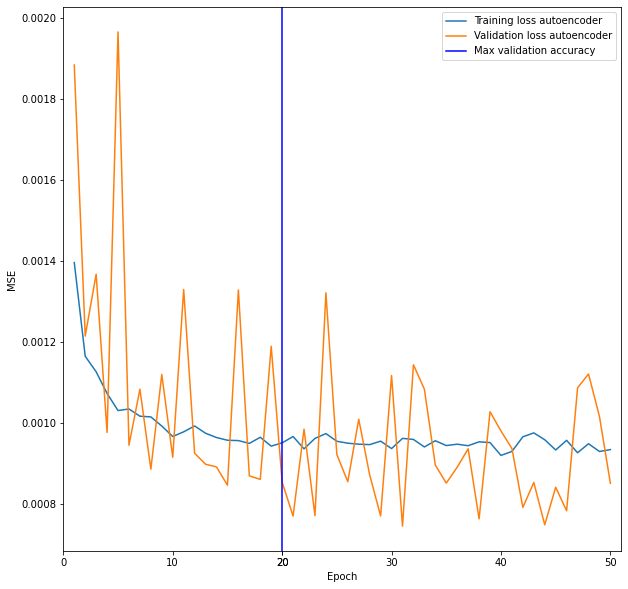

In [28]:
#generating the batch indexes
batchID = np.array([i+1 for i in range(len(train_ae))])

plt.figure(figsize=(10,10))

#plotting the losses
plt.plot(batchID,train_ae,label = "Training loss autoencoder")
plt.plot(batchID,val_ae, label = "Validation loss autoencoder")
plt.xlabel("Epoch")
plt.ylabel("MSE")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])
plt.xticks(ticks)
plt.xlim(0,batchID.max()+1)

plt.legend()

#saving the figure
#plt.savefig("Training_mse")
plt.show()

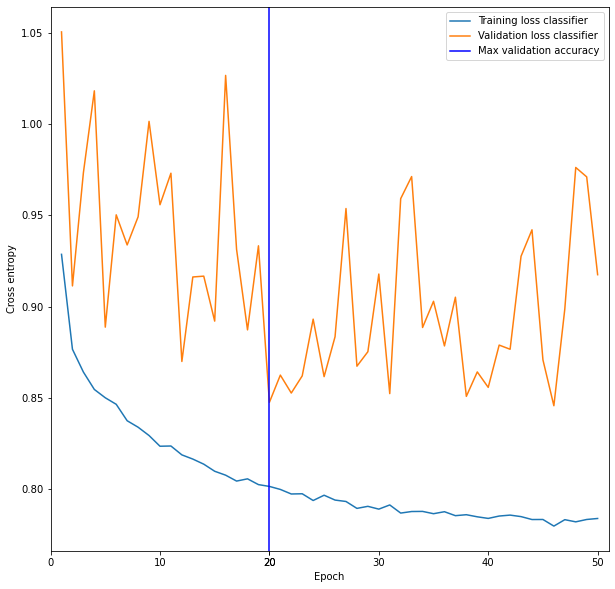

In [29]:
plt.figure(figsize=(10,10))

#plotting the losses
plt.plot(batchID,train_c,label = "Training loss classifier")
plt.plot(batchID,val_c, label = "Validation loss classifier")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])
plt.xticks(ticks)
plt.xlim(0,batchID.max()+1)
plt.legend()

#saving the figure
#plt.savefig("Training_ce")
plt.show()

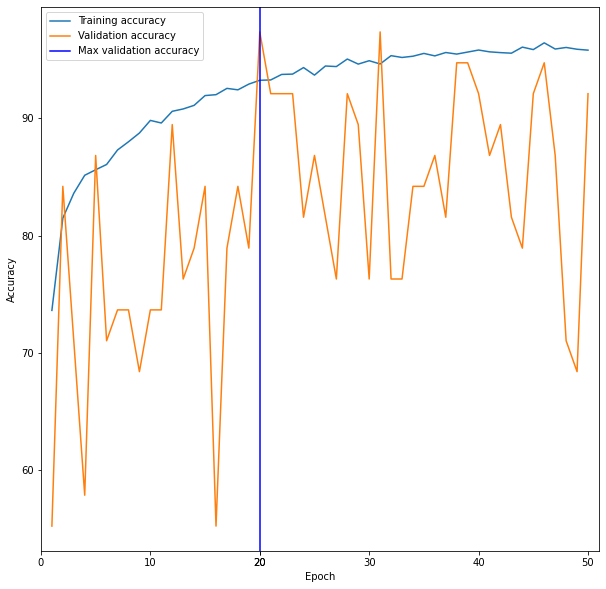

In [30]:
plt.figure(figsize=(10,10))

#plotting the losses
plt.plot(batchID,train_acc,label = "Training accuracy")
plt.plot(batchID,val_acc, label = "Validation accuracy ")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])
plt.xticks(ticks)
plt.xlim(0,batchID.max()+1)
plt.legend()

#saving the figure
#plt.savefig("Training_accuracy")
plt.show()

### Test

Notice that the value of the losses and the accuracy for the train set are computed during the training, so they are not very accurate.

In [31]:
train_dir = os.path.join(data_dir,"train","images")#images
train_dir_patches = os.path.join(data_dir,"train","images_patch")#patches
train_labels_dir = os.path.join(data_dir,"train","labels","train.json")
with open(train_labels_dir) as f:
    train_labels = json.load(f)#labels

train_dataset = HDAdatasetPatches(train_dir,train_dir_patches,train_labels,train = False,
                          transform=None,grayscale=grayscale,fft=fft)

In [32]:
test(train_dataset,"TRAIN")
test(val_dataset,"VALIDATION")
test(test_dataset,"TEST");

TRAIN set: 100%|██████████| 261/261 [01:45<00:00,  2.47it/s]


TRAIN : Autoencoder Loss: 0.0008, Classifier Loss: 0.7916,
 Accuracy patches: 94.4444 in 10440 input samples, Accuracy: 98.8506 in 261 input samples



TEST set:   0%|          | 0/75 [00:00<?, ?it/s]

VALIDATION : Autoencoder Loss: 0.0009, Classifier Loss: 0.8475,
 Accuracy patches: 86.0526 in 1520 input samples, Accuracy: 97.3684 in 38 input samples



TEST set: 100%|██████████| 75/75 [00:27<00:00,  2.76it/s]

TEST : Autoencoder Loss: 0.0008, Classifier Loss: 0.8630,
 Accuracy patches: 82.8333 in 3000 input samples, Accuracy: 85.3333 in 75 input samples

